# Health Care - Malaria

In [1]:
# importing the required libraries and reading the data
import pandas as pd 

data = pd.read_csv("Malaria.csv")

In [2]:
data

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AFR,Africa,Country,DZA,Algeria,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
1,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,ARG,Argentina,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,ARM,Armenia,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
3,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,AZE,Azerbaijan,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
4,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,BLZ,Belize,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,PER,Peru,Year,2000,...,NaN,NaN,6.92,NaN,11.15,9.00 [6.92-11.15],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2503,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,TJK,Tajikistan,Year,2000,...,NaN,NaN,9.10,NaN,9.10,9.10 [9.10-9.10],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2504,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,HTI,Haiti,Year,2000,...,NaN,NaN,5.58,NaN,15.54,9.67 [5.58-15.54],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2505,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,SEAR,South-East Asia,Country,PRK,Democratic People's Republic of Korea,Year,2000,...,NaN,NaN,9.92,NaN,9.92,9.92 [9.92-9.92],NaN,NaN,EN,2024-03-08T07:00:00.000Z


In [3]:
data["ParentLocationCode"].unique()

array(['AFR', 'AMR', 'EUR', 'SEAR', 'WPR', 'EMR'], dtype=object)

In [4]:
# removing the columns which have all null values
data.dropna(axis=1, how='all', inplace=True)

In [5]:
# removing the Value columns which don't contribute to ouroutcome of intrest
dropping_columns = [
    'Indicator', 'ValueType','FactComments', 'Language','IndicatorCode','Location type','Value','DateModified','Period type','FactValueNumericLow','FactValueNumericHigh'
]

data = data.drop(columns=dropping_columns)

In [6]:
# using simple imputer from scikit-learn to handle the missing values
from sklearn.impute import SimpleImputer

categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = data.select_dtypes(include=["number"]).columns.tolist()

# Replacing the null values in numerical columns with mean
imputer_numerical = SimpleImputer(strategy='mean')
data[numerical_cols] = imputer_numerical.fit_transform(data[numerical_cols])

# Replacing the null values in categorical columns with most-frequent item in the feature
imputer_categorical = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer_categorical.fit_transform(data[categorical_cols])

In [7]:
data

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,IsLatestYear,FactValueNumeric
0,AFR,Africa,DZA,Algeria,2022.0,True,0.00
1,AMR,Americas,ARG,Argentina,2022.0,True,0.00
2,EUR,Europe,ARM,Armenia,2022.0,True,0.00
3,EUR,Europe,AZE,Azerbaijan,2022.0,True,0.00
4,AMR,Americas,BLZ,Belize,2022.0,True,0.00
...,...,...,...,...,...,...,...
2502,AMR,Americas,PER,Peru,2000.0,False,9.00
2503,EUR,Europe,TJK,Tajikistan,2000.0,False,9.10
2504,AMR,Americas,HTI,Haiti,2000.0,False,9.67
2505,SEAR,South-East Asia,PRK,Democratic People's Republic of Korea,2000.0,False,9.92


# Data Visualization

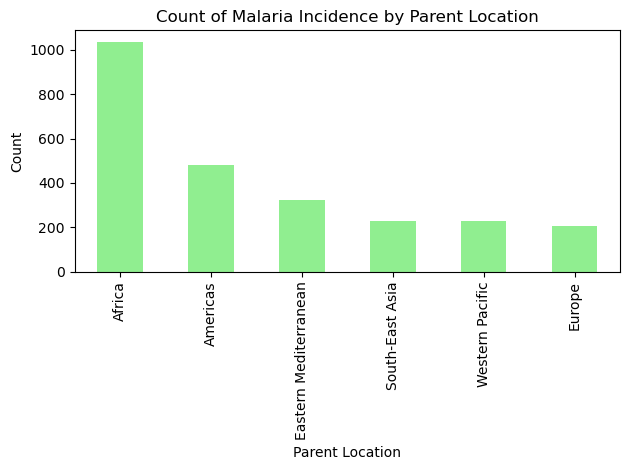

In [8]:
import matplotlib.pyplot as plt
data['ParentLocation'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Count of Malaria Incidence by Parent Location')
plt.xlabel('Parent Location')
plt.ylabel('Count')
plt.savefig("Count of Malaria Incidence by Location.png",dpi=72)
plt.tight_layout()
plt.show()


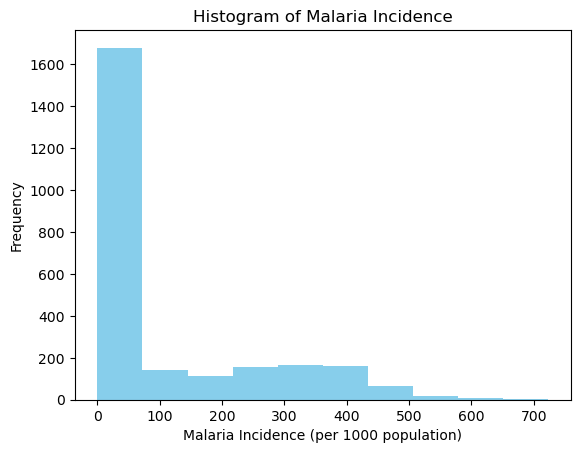

In [9]:
plt.hist(data["FactValueNumeric"], bins=10, color='skyblue')
plt.title('Histogram of Malaria Incidence')
plt.xlabel('Malaria Incidence (per 1000 population)')
plt.ylabel('Frequency')
plt.savefig("Count of Malaria Incidence.png",dpi=72)
plt.show()

In [10]:
data= data.rename(columns = {"ParentLocationCode":"WHORegionCode","ParentLocation":"WHORegion","SpatialDimValueCode":"Country Code","Location":"Country",
                            "Period":"Year","FactValueNumeric":"Malaria Incidence"})

In [11]:
# Applying encoding for categorcial features 

from sklearn.preprocessing import LabelEncoder
Le_location = LabelEncoder()
Le_parentlocationcode = LabelEncoder()
Le_SpatialDimValueCode = LabelEncoder()
Le_ParentLocation = LabelEncoder()


data['Country'] = Le_location.fit_transform(data['Country'])
data['WHORegionCode'] = Le_parentlocationcode.fit_transform(data['WHORegionCode'])
data['Country Code'] = Le_SpatialDimValueCode.fit_transform(data['Country Code'])
data['WHORegion'] = Le_ParentLocation.fit_transform(data['WHORegion'])


In [12]:
Mean = data['Malaria Incidence'].mean()
Std =  data['Malaria Incidence'].std()

In [13]:
# Applying the standardization to the numerical features such that all the features will be on same scale which is required for the model to perform analysis effectively
from sklearn.preprocessing import StandardScaler


scaler_period = StandardScaler()
scaler_mi = StandardScaler()
data['Year'] = scaler_period.fit_transform(data[['Year']])
data['Malaria Incidence'] = scaler_mi.fit_transform(data[['Malaria Incidence']])


In [14]:
# Identifying the outliers using IQR and removing them
Q1 = data['Malaria Incidence'].quantile(0.25)
Q3 = data['Malaria Incidence'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
data = data[(data['Malaria Incidence'] >= (Q1 - 1.5 * IQR)) & (data['Malaria Incidence'] <= (Q3 + 1.5 * IQR))]


In [15]:
data

,WHORegionCode,WHORegion,Country Code,Country,Year,IsLatestYear,Malaria Incidence
0,0,0,27,1,1.658312,True,-0.678212
1,1,1,3,3,1.658312,True,-0.678212
2,3,3,4,4,1.658312,True,-0.678212
3,3,3,5,5,1.658312,True,-0.678212
4,1,1,10,7,1.658312,True,-0.678212
...,...,...,...,...,...,...,...
2502,1,1,74,77,-1.658312,False,-0.617766
2503,3,3,95,93,-1.658312,False,-0.617094
2504,1,1,43,46,-1.658312,False,-0.613266
2505,4,4,77,26,-1.658312,False,-0.611587


In [16]:
# Moving the Valuenumeric to last column as this is our outcome of intrest
column_to_move = "Malaria Incidence"
data = data[[col for col in data.columns if col != column_to_move] + [column_to_move]]

X = data.drop(columns=['Malaria Incidence'])
Y = data['Malaria Incidence']

In [17]:
# splitting the data into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=2)
model.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=2)

In [19]:
# Making predictions using the test data
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

R2_Score = r2_score(Y_test,y_pred)

print("R2_Score of the model is:",R2_Score)

R2_Score of the model is: 0.9872173079258345


In [20]:
data['IsLatestYear'] = data['IsLatestYear'].astype(int)

In [21]:
data

,WHORegionCode,WHORegion,Country Code,Country,Year,IsLatestYear,Malaria Incidence
0,0,0,27,1,1.658312,1,-0.678212
1,1,1,3,3,1.658312,1,-0.678212
2,3,3,4,4,1.658312,1,-0.678212
3,3,3,5,5,1.658312,1,-0.678212
4,1,1,10,7,1.658312,1,-0.678212
...,...,...,...,...,...,...,...
2502,1,1,74,77,-1.658312,0,-0.617766
2503,3,3,95,93,-1.658312,0,-0.617094
2504,1,1,43,46,-1.658312,0,-0.613266
2505,4,4,77,26,-1.658312,0,-0.611587


## Malaria Incidence per 1000 population in different Countries of World Health Organization Regions in 2025

Enter the WHO Region and its Code:

WHO Regions and its Codes:
+ 'Africa' - 'AFR' 
+ 'Americas' - 'AMR'
+ 'Europe'   - 'EUR'
+ 'South-East Asia' - 'SEAR'+  'Western Pacific - 'WPR'
+  'Eastern Mediterranean - 'EMR'



In [22]:
WHO_Region = input("Please enter the WHO Region")
WHO_Region_Code = input("Please enter the WHO Region Code")
pl_encoded_value  = Le_ParentLocation.transform([WHO_Region])[0]
pl_code_encoded_value  = Le_parentlocationcode.transform([WHO_Region_Code])[0]
prediction_data = data[data["WHORegion"] == pl_encoded_value][0:15]
SDVC = prediction_data["Country Code"].tolist()
LOC  = prediction_data["Country"].tolist()
IsLatestYear = 1

prediction_data = []
import numpy as np
for i, (sdvc,loc) in enumerate(zip(SDVC,LOC)):
    future_data = {
    'WHORegionCode':pl_code_encoded_value,
    'WHORegion': pl_encoded_value,
    'Country Code':sdvc,
    'Country': loc,
    'Year': 2025,
    'IsLatestYear': IsLatestYear,
    }
    input_data = pd.DataFrame(future_data, index=[0])
    # Standardizing the Period as we have done the same for year during model training
    input_data[['Year']] = scaler_period.transform(input_data[['Year']])
    prediction = model.predict(input_data)

    # Perfroming the inverse transform on malaria incidence as we have standaridized it during preprocessing
    original_prediction = scaler_mi.inverse_transform(np.array([prediction]))

    prediction_data.append({"Country":Le_location.inverse_transform([loc])[0],
                            "Malaria Incidence":original_prediction[0][0]
                           })
    

#Storing the predicted data in a DataFrame
prediction_data = pd.DataFrame(prediction_data)

prediction_data

Please enter the WHO Region South-East Asia
Please enter the WHO Region Code SEAR


,Country,Malaria Incidence
0,Bhutan,0.008
1,Nepal,0.004
2,Sri Lanka,0.000
3,Timor-Leste,0.001
4,Democratic People's Republic of Korea,0.195
5,Thailand,0.205
6,Bangladesh,0.855
7,Myanmar,7.065
8,India,3.915
9,Indonesia,3.575


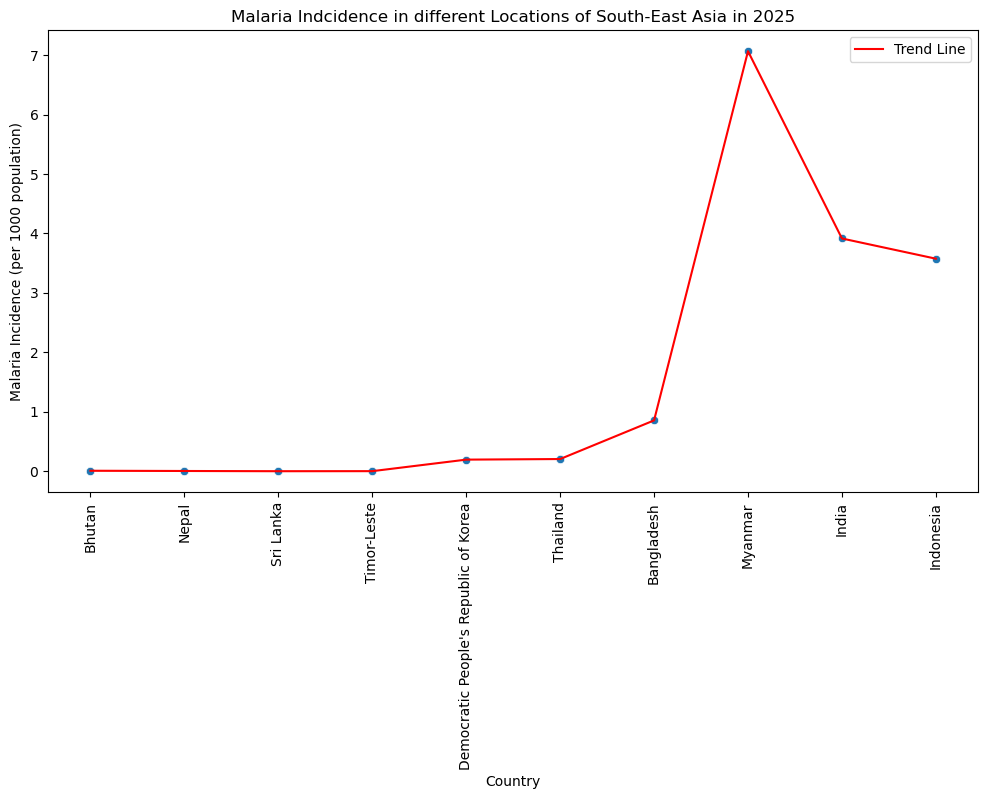

In [26]:
import seaborn as sns

plt.figure(figsize=(12, 6))


sns.scatterplot(data= prediction_data,x="Country",y="Malaria Incidence")
sns.lineplot(data= prediction_data,x="Country",y="Malaria Incidence", color='red', label='Trend Line')
plt.title(f'Malaria Indcidence in different Locations of {WHO_Region} in 2025')
plt.xlabel('Country')
plt.ylabel('Malaria Incidence (per 1000 population)')
plt.xticks(rotation=90)
plt.savefig(("Malaria Incidence (per 1000 population)"),dpi=100,bbox_inches='tight')
plt.show()